In [289]:
import math
%tensorflow_version 2.x
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version:" + tf.__version__)

Tensorflow version:2.4.1


In [290]:
#initializing variables a and b
a=1
b=4

In [291]:
#sum the two variables
a+b

5

In [292]:
#@title "Hidden Celll"
def display_sinosoid():
  M=range(180)
  N=[math.sin(x/10.0) for x in M]
  plt.plot(M,N)
  

In [293]:
#boilerplate code try catch
try:
  # detected TPU
  tpus=tf.distribute.cluster_resolver.TPUClusterResolver()   
except ValueError:
  tpus=None
  gpus=tf.config.experimental.list_logical_devices("GPu")

#here we select the distribution strategy for the selected hardwares TPU or GPU
if tpus:
  tf.config.experimental_connect_to_cluster(tpus)
  tf.tpu.experimental.initialize_tpu_system(tpus)
  strategy=tf.distribute.experimental.TPUStrategy(tpus)
  print('Hardware running on is TPU', tpu.master())
elif len(gpus) >0:
  #will work for multiple GPUs
  strategy= tf.distribute.MirroredStrategy(gpus)
  print('hardware running on is',len(gpus),'GPUs' )
else:
  #getting the default strategy working on CPU and single GPU
  strategy=tf.distribute.get_strategy()
  print('hardware running on CPU')

#getting the number of accelerators
print("the number of accelerators:",strategy.num_replicas_in_sync)  


hardware running on CPU
the number of accelerators: 1


In [294]:
#datafiles are stored in GCS cloud hence their address starts with gs://
BATCH_SIZE=128
EPOCHS=10
training_img_file='gs://mnist-public/train-images-idx3-ubyte'
training_label_file='gs://mnist-public/train-labels-idx1-ubyte'
validation_img_file='gs://mnist-public/t10k-images-idx3-ubyte'
validation_label_file='gs://mnist-public/t10k-labels-idx1-ubyte'

In [295]:
#importing all the necessary libs
import os,re,math,json,shutil,pprint
import PIL.Image,PIL.ImageFont,PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("the tensorflow version is " + tf.__version__)

the tensorflow version is 2.4.1


In [296]:
#@title Another Hidden Cell for helper functions

# these are helper functions and matplotlib configurations
plt.ioff
plt.rc('image',cmap='gray_r')
plt.rc('grid',linewidth=1)
plt.rc('xtick',top=False,bottom=False,labelsize='large')
plt.rc('ytick',left=False,right=False,labelsize='large')
plt.rc('axes',facecolor='F8F8F8',titlesize="large",edgecolor='white')
plt.rc('text',color='a8151a')
plt.rc('figure',facecolor='F0F0F0',figsize=(17,10))
#fonts for matplotlib
FONT_DIR_MATPLOTLIB=os.path.join(os.path.dirname(plt.__file__),"mpl-data/fonts/ttf")
#we pull a batch from our both training and validation datasets
def dataset_2_numpy_util(training_data,validation_data,N):
  # from the N training digits take the first batch of 100000 digits
    batch_train_ds=training_data.unbatch().batch(N)

  #executing_eagerly, looping normally
    if tf.executing_eagerly():
      for validation_digits,validation_labels in validation_data:
         validation_digits=validation_digits.numpy()
         validation_labels=validation_labels.numpy()
         break
      for training_digits,training_labels in batch_train_ds:
         training_digits=training_digits.numpy()
         training_labels=training_labels.numpy()
         break
    else:
      v_images,v_labels=validation_data.make_one_shot_iterator().get_next()
      t_images,t_labels=batch_train_ds.make_one_shot_iterator().get_next()
      # running takes one batch and session. gives out numpy results
      with tf.Session() as ses:
        (validation_digits,validation_labels,training_digits,training_labels)=ses.run([v_images,v_labels,t_images,t_labels])

     #one-hot encoded (coding to numerals) values in dataset
    validation_labels=np.argmax(validation_labels,axis=1)
    training_labels=np.argmax(training_labels,axis=1)
    return (training_digits,training_labels,validation_digits,validation_labels)
# for testing by creating digits from the on system local fonts
def create_dgts_frm_lcl_fnts(n):
  font_labels = []
  # format 'LA': black in chanel 0, alpha in chanel 1
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) 
  font1 = PIL.ImageFont.truetype(os.path.join(FONT_DIR_MATPLOTLIB, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(FONT_DIR_MATPLOTLIB, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  # black in chanel 0, alpha in chanel 1 (discarded)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 
  
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# function to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    # bad predictions are in red
    if predictions[i] != labels[i]: t.set_color('red')
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# function to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
   display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        if k=='batch' or k=='size':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)


In [297]:
AUTO = tf.data.experimental.AUTOTUNE
#function to read the labels
def read_labl(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
#reading the image
def rd_img(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
#loading the dataset  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(rd_img, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_labl, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
#getting the training dataset shuffling thru each iteration,repeating for keras,fixing the batch size and then fetching next batch until the current batch is trained  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # small dataset can be cached  in RAM and in case of tpu its good to get good performance for small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # repeating for Keras
    dataset = dataset.batch(batch_size, drop_remainder=True) # by dropping_remainder we are fixing the batch size 
    dataset = dataset.prefetch(AUTO)  # fetching next batch until the current batch is trained  (-1: autotune prefetch buffer size)
    return dataset
#getting the validation dataset caching,repeating for keras,fixing the batch size
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() #  small dataset can be cached  in RAM and in case of tpu its good to get good performance for small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in evaluation  dataset, all in one batch
    dataset = dataset.repeat() # repeating for Keras
    return dataset

# instantiating the datasets
training_dataset = get_training_dataset(training_img_file, training_label_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_img_file, validation_label_file)

# function returns the dataset for tpu
training_input_fn = lambda: get_training_dataset(training_img_file, training_label_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_img_file, validation_label_file)

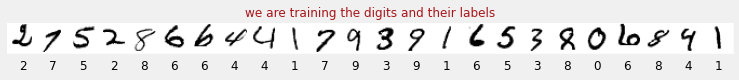

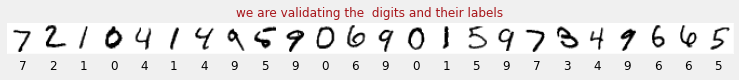

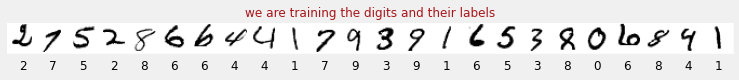

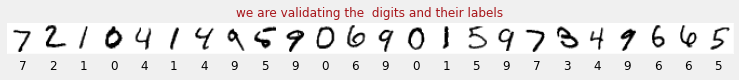

In [298]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_2_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "we are training the digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "we are validating the  digits and their labels", N)
font_digits, font_labels = create_dgts_frm_lcl_fnts(N)

In [299]:
#model training using activation function as softmax and loss is categorical_crossentropy
'''
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(10, activation='softmax')

      #introducing multiple sequential layers. the loss goes out the roof
      #tf.keras.layers.Input(shape=(28*28,)),
      #tf.keras.layers.Dense(200, activation='sigmoid'),
      #tf.keras.layers.Dense(60, activation='sigmoid'),
      #tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# printing model layers
model.summary()

# function callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

#replacing the sigmoid functions with RELU
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

#optimizer=tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
'''
'''
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=10)
'''

"\nmodel.compile(optimizer='adam',\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n\n# print model layers\nmodel.summary()\n\n# utility callback that displays training curves\nplot_training = PlotTraining(sample_rate=10, zoom=10)\n"

In [300]:
'''
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, activation='relu', padding='same', strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# function callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)
'''

"\nmodel = tf.keras.Sequential(\n  [\n      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),\n      tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation='relu', padding='same'),\n      tf.keras.layers.Conv2D(kernel_size=6, filters=24, activation='relu', padding='same', strides=2),\n      tf.keras.layers.Conv2D(kernel_size=6, filters=32, activation='relu', padding='same', strides=2),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(200, activation='relu'),\n      tf.keras.layers.Dense(10, activation='softmax')\n  ])\n\nmodel.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n\n# print model layers\nmodel.summary()\n\n# function callback that displays training curves\nplot_training = PlotTraining(sample_rate=10, zoom=16)\n"

In [301]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# function callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 12)        36        
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 24)      

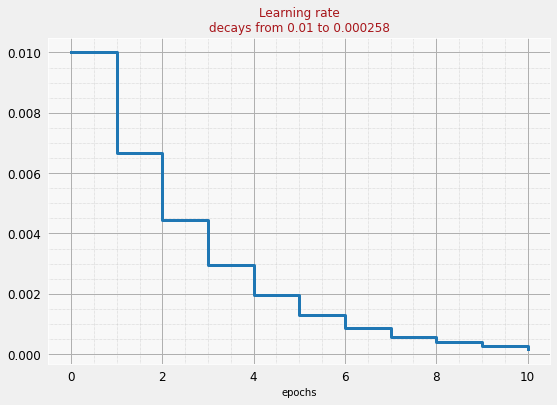

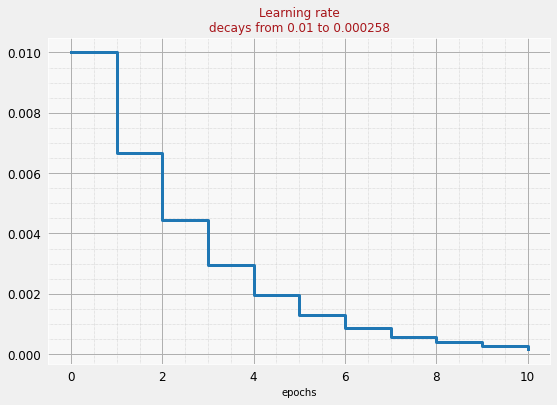

In [302]:
#learning rate schedule
# lr decay function
def lr_decay(epoch):
  #return 0.01 * math.pow(0.6, epoch)
  return 0.01 * math.pow(0.666, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

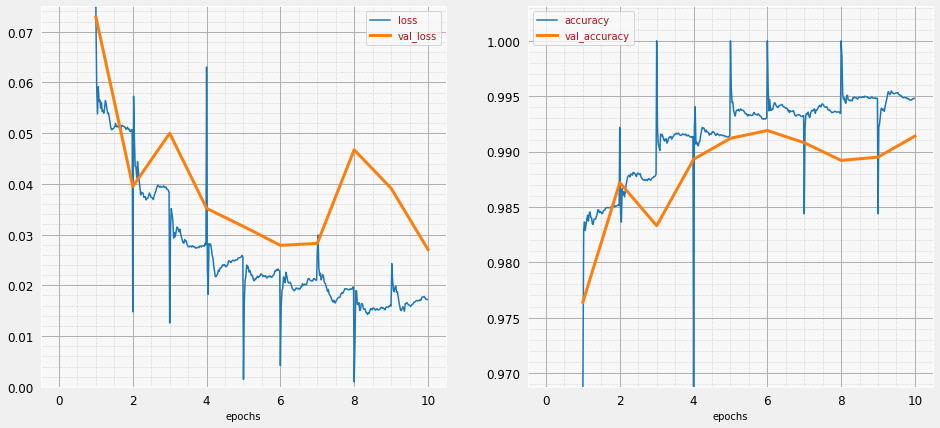

In [303]:
# there are 60,000 items in this dataset
steps_per_epoch = 60000//BATCH_SIZE
print("The Steps per epoch: ", steps_per_epoch)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

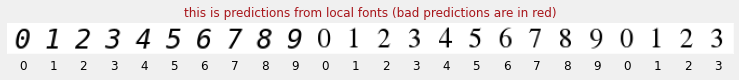

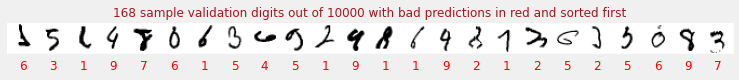

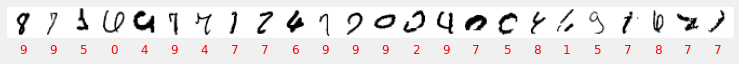

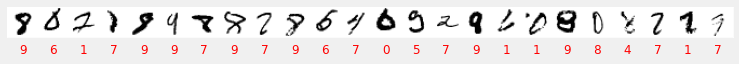

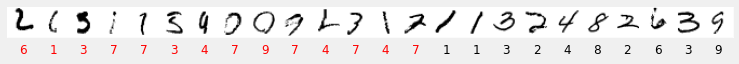

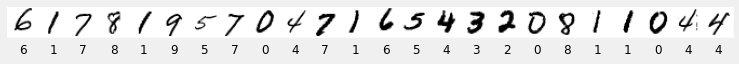

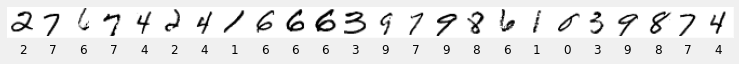

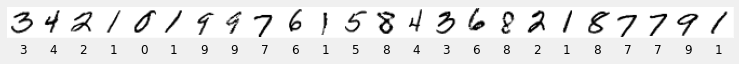

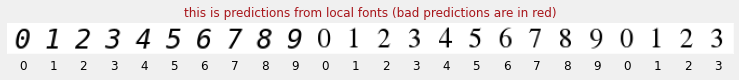

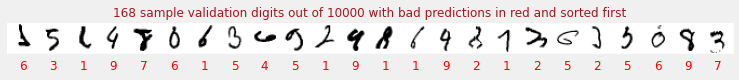

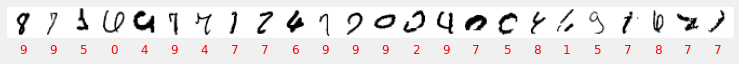

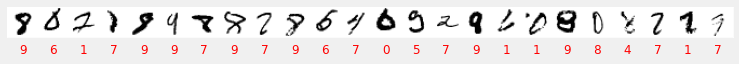

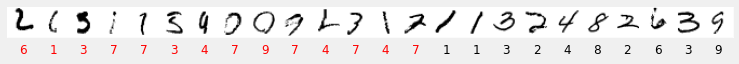

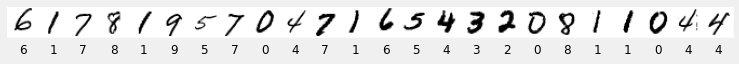

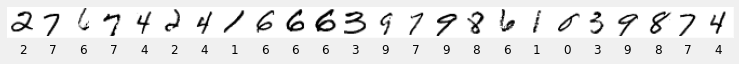

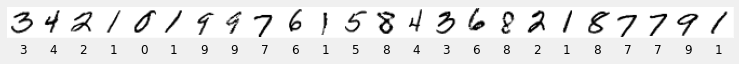

In [304]:
#visualizing the predictions.The axis=1 parameter is needed,we have processed a batch of 128 images and therefore the model returns 128 vectors of probabilities. The shape of the output tensor is [128, 10]. We are computing the argmax across the 10 probabilities returned for each image, thus axis=1 (the first axis being 0)
# prediction from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "this is predictions from local fonts (bad predictions are in red)", N)

# recognizing validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)